In [1]:
## import all the packages needed
import praw
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import xgboost as xgb
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
plt.style.use('fivethirtyeight') 
%matplotlib inline 
pd.options.mode.chained_assignment = None
init_notebook_mode(connected=True)

### 1) Data collection

**To colect the data from SnapLenses subreddit I have been using `praw` package wich allows to connect to reddit API.**

In [2]:
## setting up
reddit = praw.Reddit(client_id='***', \
                     client_secret='***', \
                     user_agent='***', \
                     username='***', \
                     password='***')

subreddit = reddit.subreddit('SnapLenses') # set the subreddit name

In [3]:
## we will gather all topics from subreddit (limit=None)
top_subreddit = subreddit.new(limit=None)

In [4]:
## creation of dictionary which will hold the data
topics_dict = {"title":[],
               "score":[], 
               "flair_text":[],
               "comms_num":[], 
               "created":[], 
               "body":[],
               "author":[],
               "is_video":[],
               "is_self":[],
               "id":[]}

In [5]:
## fill the dictionary with the information needed from reddit
for submission in top_subreddit:
    topics_dict["title"].append(submission.title)
    topics_dict["score"].append(submission.score)
    topics_dict["flair_text"].append(submission.link_flair_text)
    topics_dict["comms_num"].append(submission.num_comments)
    topics_dict["created"].append(submission.created)
    topics_dict["body"].append(submission.selftext)
    topics_dict["author"].append(submission.author)
    topics_dict["is_video"].append(submission.is_video)
    topics_dict["is_self"].append(submission.is_self)
    topics_dict["id"].append(submission.id)

In [6]:
## convert disctionary to pandas Data Frame for easier manipulation
topics_data = pd.DataFrame(topics_dict)

In [7]:
## defining the function that will convert 'created' column to date-time column which is easier to understand
def get_date(created):
    return datetime.fromtimestamp(created)

topics_data = topics_data.assign(timestamp = topics_data["created"].apply(get_date)) 

topics_data = topics_data.drop('created', axis=1) # remove the 'created' column

In [8]:
topics_data.sample(5) # take a look at the data

,author,body,comms_num,flair_text,id,is_self,is_video,score,title,timestamp
552,Jinnie_the_Wew,,8,NEW FACE LENS,8ngbe4,False,True,6,"LUV SUX - Face Lens [audio, animated, face]",2018-05-31 17:55:20
456,Unic_,Can someone Make and Edna Mode filter with her...,1,REQUEST,8qda0v,True,False,3,Edna Mode,2018-06-12 08:34:28
92,spewds41,Can someone please do the smash bros joins the...,0,REQUEST,93nku4,True,False,1,Lens request,2018-08-01 20:48:33
44,Frozen_Atlas,,3,None,95py82,False,False,20,Gopnik Award,2018-08-09 07:53:17
956,Jinnie_the_Wew,,14,NEW FACE LENS,8dp1ha,False,True,146,"Pupil dialate/un-dialate lens! [Face, Animated...",2018-04-21 03:45:03


***
### 2) Make the plot of topics by days. Is there an upward or downward trend?

In [9]:
def topics_by_time(period, period_str='Period'):
    """
    Function topics_by_time plots the amount of topics by specific period of time.
    
    Input:
    period - period you want to group your data by (in format: topics_data.timestamp.dt.X, X is (hour/day/year))
    period_str - string of selected period (e.g. 'Hour', 'Day', 'Year')
    Call example: mean_by_time(period=topics_data.timestamp.dt.hour, period_str='Hour)
    
    Output:
    Plot with count of topics by specific period
    """
    Temp = []
    Temp = topics_data.groupby(period)[['author']].count()
    Temp.columns = ['Topics']
    Temp.index.name = period_str
    
    data = [go.Scatter(
        x = Temp.index,
        y = Temp.Topics,
        line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 1)
    )]
    
    layout = go.Layout(
    title=str('Total Amount of Topics by ' + period_str),
    xaxis=dict(title=period_str),
    yaxis=dict(title='Topics')
    )

    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [10]:
topics_by_time(period=topics_data.timestamp.dt.date, period_str='Date')

In [11]:
topics_by_time(period=topics_data.timestamp.dt.weekofyear, period_str='Week Number')

**Looking on the second plot (*Topics by Week number*) we can see that total amount of topics trends down. The same can be viewed  on the first plot (*Topics by Date*). There was a peak when subreddit just started, but slowly the number of topics go down.**

In [12]:
topics_by_time(period=topics_data.timestamp.dt.weekday, period_str='Weekday (0= Monday, 6=Sunday)')

**Looking at this plot we can see that on *Sunday* people are not as active as on *Tuesday* or *Saturday*.**

***
### 3) Who is the most active redditor? 

In [13]:
topics_data.author = topics_data.author.apply(lambda x: str(x)) 
topics_data.flair_text = topics_data.flair_text.apply(lambda x: str(x)) # convert columns to string type

In [14]:
## df1 - dataframe with average score and author name as index
## df2 - dataframe with count of topics and author name as index
## users - merged dataframe of df1 and df2
df1 = topics_data.groupby('author')[['score']].mean()
df1.columns = ['avg_score']
df2 = topics_data.groupby('author')[['score']].count()
df2.columns = ['total_topics']
users = pd.merge(df1, df2,
                 left_index= True, right_index= True)

**First, let's take a look what redditors posted the most in subreddit:**

In [15]:
users = users.sort_values(by=['total_topics']) # sort by 'total_topics' column

data = [go.Bar(x=users.total_topics[-25:], # selection of the highest 25 values
               y=users.index[-25:], 
               orientation='h')]
layout = go.Layout(
    title='Total Amount of Topics by Users',
    xaxis=dict(title='Topics'),
    yaxis=dict(title='User Name')
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

**Then, let's take a look which redditors have the highest average score:**

In [16]:
users = users.sort_values(by=['avg_score'])

data = [go.Bar(x=users.avg_score[-25:],
              y=users.index[-25:], 
              orientation='h')]
layout = go.Layout(
    title='Average Score by Users',
    xaxis=dict(title='Score'),
    yaxis=dict(title='User Name')
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

**Let's look at the correlation between total score and topics and find who has the most topics posted *and* highest average score.**

In [17]:
data = [
    go.Scatter(
        x=users.avg_score,
        y=users.total_topics,
        mode='markers',
        text=users.index
    )
]

layout = go.Layout(
    title='Total Average Score vs Total Topics',
    xaxis=dict(title='Average Score'),
    yaxis=dict(title='Topics')
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

**We can see that having a lot of posts doesn't always mean that you will get tho highest score as in case for *Frozen_Atlas* (28 posts vs 56 score). There is also another oulier *oops_caps* whos average score is 1929 with just 2 posts.**

***
### 4) The most popular topics by number of comments and upvotes

In [18]:
## creat a new DF with 2 columns - sum of score and sum of comments with post id as index
ids = topics_data.groupby('id')[['score', 'comms_num']].sum()

**Firstly, let's look how number of comments is connected with score through scatter plot.**

In [19]:
data = [go.Scatter(
        x=ids.score,
        y=ids.comms_num,
        mode='markers',
        text=ids.index
)
]

layout = go.Layout(
    title='Score vs Comments',
    xaxis=dict(title='Score'),
    yaxis=dict(title='Comments')
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

**It looks like there is a positive correlation between these variables (as score goes up the number of comments also goes up).**

**Now we will find the best topics: topics should have total score higher than .98 quantile of total distribution (or simply saying, the highest 2% among all topics) and the same for amount of comments.**

In [20]:
thresh = .98
score_thresh = int(ids.score.quantile(thresh))
comm_thresh = int(ids.comms_num.quantile(thresh))

best_ids = list(ids[(ids.score >= score_thresh) & (ids.comms_num >= comm_thresh)].index)

In [21]:
best_ids_df = topics_data[topics_data.id.isin(best_ids)]
display(best_ids_df)

,author,body,comms_num,flair_text,id,is_self,is_video,score,title,timestamp
142,AngrierBearcat,,50,None,91umoe,False,False,961,"I know this is low effort, but can some one ma...",2018-07-26 05:49:06
208,valstroyerr,,43,REQUEST,8yszvm,False,False,1350,Can anyone make a snaplens like this?,2018-07-14 23:42:23
220,robin-dela,,51,NEW LENS 3D,8yk3vw,False,True,1014,AR Message,2018-07-14 00:47:28
242,whichuserami,,50,REQUEST,8xse54,False,True,1096,[REQUEST] This goofy mf with the music pleas e,2018-07-11 06:20:43
464,oops_caps,,74,NEW LENS 3D,8q961a,False,True,2908,AR Earthquake Lens,2018-06-11 23:34:55
574,Bennyp3333,,47,Definitely not removed because the mod definit...,8mob61,False,True,1758,"If a pretty girl can get hundreds of likes, ho...",2018-05-28 18:30:04
650,ApocTheLegend,,174,PROGRESS UPDATE,8k9a2o,False,True,2804,The sacred lens is nearing completion,2018-05-18 11:56:12
716,atv_suplex,,43,NEW LENS 2D,8ijgxb,False,True,1600,Glitch Effect Lens,2018-05-11 10:58:23
821,Jinnie_the_Wew,,87,NEW LENS 2D,8g79g1,False,True,1475,"Screaming kid [Gyro activated, smooth transiti...",2018-05-01 20:52:02


**7/9 of this topics have video inside which can make them more popular. Also 4/9 of topics have the new lenses submissions.**

***
### 5) Is there a correlation between upvotes and comments?

**As we could see visually it looked like there is a correlation. If we calculate the value we will get:**

In [22]:
x = topics_data.comms_num
y = topics_data.score
print("Correlation between Number of Comments and Total Score is:", round(np.corrcoef(x, y)[0,1], 2))
## the reason we subset [0,1] value is that np.corrcoef returns correlation matrix between variables

Correlation between Number of Comments and Total Score is: 0.75


**We can say that there is strong correlation (.75) between these two variables.**

***
### 6) Is it possible to distinguish variables that help to predict whether topics will be popular (high number of upvotes) or not? 

**I will build a XGB (Extreme Gradient Boosting) model to see whether the score value can be predicted by other variables.**

**I assume that topic popularity depends on time of the day topic was made, day of the week, the category, the video content (*yes/no*), whether the topic was created by top user (users with the highest average score) and whether topics refers to another URL (*yes/no*).**

In [23]:
## remove columns we don't need for model
model_df = topics_data.drop(['body', 'comms_num', 'id', 'title'], axis=1)

In [24]:
## create a list of top 25 users from 'users' DF
users = users.sort_values(by=['avg_score'], ascending=False)
top_25_users = users.index[1:50].tolist()

In [25]:
model_df['is_top_user'] = False
model_df.is_top_user[model_df.author.isin(top_25_users)] = True
model_df = model_df.drop(['author'], axis=1)

In [26]:
model_df.groupby('flair_text').size() 

flair_text
ADVERTISEMENT                                                        5
DISCUSSION                                                          40
Definitely not removed because the mod definitely isn't dum dum      1
MEME                                                                53
MEME (dirty screen trigger warning)                                  1
NEW FACE LENS                                                      182
NEW LENS 2D                                                        122
NEW LENS 3D                                                         93
None                                                               217
Official Lens Studio Team                                            1
PROGRESS UPDATE                                                     15
REQUEST                                                            265
REQUEST | Possible Spoiler                                           2
REQUEST | Potential Spoiler                                       

In [27]:
model_df['category'] = "Other"

## clean up the 'flair_text' column
model_df.category[model_df.flair_text.apply(lambda x: x.find('MEME')) >= 0] = 'Meme'
model_df.category[model_df.flair_text.apply(lambda x: x.find('REQUEST')) >= 0] = 'Request'
model_df.category[model_df.flair_text.apply(lambda x: x.find('LENS')) >= 0] = 'New lens'
model_df.category[model_df.flair_text.apply(lambda x: x.find('ADVERTISEMENT')) >= 0] = 'Ads'
model_df.category[model_df.flair_text.apply(lambda x: x.find('None')) >= 0] = 'None'

model_df.groupby('category').size()

category
Ads           5
Meme         54
New lens    397
None        217
Other        57
Request     268
dtype: int64

In [28]:
## create a new column 'score_str' which will hold a value about the score - is it below average or above average?
model_df['score_str'] = "x"
model_df.score_str[model_df.score <= model_df.score.quantile(.5)] = "below_avg"
model_df.score_str[model_df.score > model_df.score.quantile(.5)] = "above_avg"

In [29]:
model_df.groupby('score_str').size() #just take a look at the count of topics for each score

score_str
above_avg    488
below_avg    510
dtype: int64

In [30]:
## create two columns that will hold an information about time of the day (morning/day/...) and day of the week (monday/tuesday/...)
model_df['weekday'] = "x"
model_df['day_period'] = "x"

In [31]:
model_df.weekday = model_df.timestamp.dt.weekday_name #assign the day of the week from 'timestamp' columns to the 'weekday' column

In [32]:
night = (model_df.timestamp.dt.hour > 23) | (model_df.timestamp.dt.hour <= 5)
morning = (model_df.timestamp.dt.hour > 5) & (model_df.timestamp.dt.hour <= 11)
day = (model_df.timestamp.dt.hour > 11) & (model_df.timestamp.dt.hour <= 17)
evening = (model_df.timestamp.dt.hour > 17) & (model_df.timestamp.dt.hour <= 23)

model_df.day_period[night] = 'night'
model_df.day_period[morning] = 'morning'
model_df.day_period[day] = 'day'
model_df.day_period[evening] = 'evening'

In [33]:
model_df = model_df.drop(['score', 'timestamp', 'flair_text'], axis=1)

In [34]:
## convert the variable to numerical values with LabelEncoder() funstion
columns = ['day_period', 'weekday', 'category', 'is_self', 'is_video']

le = LabelEncoder()
model_df[columns] = model_df[columns].apply(lambda x: le.fit_transform(x))

In [35]:
y = model_df.score_str #labels
X = model_df.drop(['score_str'], axis=1) #variables

In [36]:
## train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

**Train the GBM model: `score ~ (day_period + weekday + flair_text + is_self + is_video)`**

In [37]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', 
                              max_depth=6,
                              learning_rate=0.01,
                              seed=123) 
xgb_model.fit(X_train, y_train) #train the model on train set
y_pred = xgb_model.predict(X_test) #predict on test set
print(classification_report(y_test, y_pred)) #print the performance

             precision    recall  f1-score   support

  above_avg       0.78      0.56      0.65       120
  below_avg       0.68      0.85      0.76       130

avg / total       0.73      0.71      0.70       250



In [38]:
confusion_matrix(y_test, y_pred)

array([[ 67,  53],
       [ 19, 111]])

**We can see that model performance is not that good (0.71 accuracy rate). **

**Let's find out which variables have a biggest impact on score:**

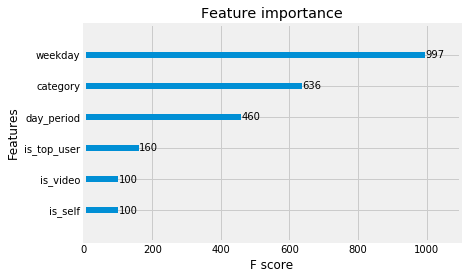

In [39]:
xgb.plot_importance(xgb_model)
plt.show()

**The fact that post has video doesn't affect the popularity of the topic. The same for the fact whether topic is created on reddit or refers to another URL. However, the time and day when users make the post have a big impact on the score as well as the category of the topic.**

***
### 7) What conclusions can be made according to this data? How can they be be helpful for the business?

* **Firstly, there is a correlation between comments and upvotes. It might make sense to use comment bots to create artificial comments to the topics. *People might think - okay, this topics has 10+ comments, that must be interesting, I'll go and check for myself.* This will lead to higher traffic in the subreddit and higher upvotes number. **

* **Secondly, we know who are the most active redditors, and these people are more likely to be interested in Snap products. We could check if they are active at other sureddits (high number of upvotes or high number of followers) and make something like "influencer marketing". So those people could be paid for promoting Snap in other related subs.**

* **Thirdly, we could check top 10-15 topics (highest number of upvotes) and see if there is something similar among them (maybe people respond more to funny content) and use this .**